In [53]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
df=pd.read_csv('emails.csv')
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [25]:
df.groupby('spam').describe()

text                                                               
     count unique                                                top freq
spam                                                                     
0     4360   4327  Subject: * special notification * aurora versi...    2
1     1368   1368  Subject: naturally irresistible your corporate...    1

In [26]:
df['spam'].value_counts()

0    4360
1    1368
Name: spam, dtype: int64

In [27]:
1368/4360

0.3137614678899083

In [28]:
df_spam=df[df['spam']==1]
df_spam.shape

(1368, 2)

In [29]:
df_ham=df[df['spam']==0]
df_ham.shape

(4360, 2)

In [30]:
df_ham_downsampled=df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(1368, 2)

In [31]:
df_balanced=pd.concat([df_spam,df_ham_downsampled])
df_balanced.shape

(2736, 2)

In [32]:
df_balanced['spam'].value_counts()

1    1368
0    1368
Name: spam, dtype: int64

In [33]:
df_balanced.sample(5)

,text,spam
1723,Subject: re : choosing the riskfree rate dear...,0
8,Subject: undeliverable : home based business f...,1
359,Subject: start shopping at costco today with a...,1
5529,Subject: thanks dear mr . kaminski : thank y...,0
3383,"Subject: recommendations vince and joe , thi...",0


In [34]:
X_train,X_test,y_train,y_test=train_test_split(df_balanced['text'],df_balanced['spam'],
                                               test_size=0.2,random_state=101,
                                               stratify=df_balanced['spam'])

In [35]:
X_train.head()

5444    Subject: agenda for transmission roundtable on...
5282    Subject: value lab meeting on the lst of augus...
890     Subject: you don _ t know how to get into sear...
749     Subject: claim your free $ 1000 home depot gif...
908     Subject: mail delivery failed : returning mess...
Name: text, dtype: object

In [36]:
preprocess_url='https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3'
encoder='Documents/New folder'

In [37]:
def get_sentence_embedding(sentence):
    bert_preprocess=hub.KerasLayer(preprocess_url)
    preprocessed_text=bert_preprocess(sentence)
    bert_encoder=hub.KerasLayer(encoder)
    return bert_encoder(preprocessed_text)['pooled_output']

In [38]:
get_sentence_embedding([
    '500$ discount. hurry up',
    'Bhavin, are you up for a volleyball game tomorrow?'
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[ 0.0732795 , -0.24222304,  0.77541345, ..., -0.7764012 ,
         0.37399358,  0.9943151 ],
       [-0.16002959, -0.48740003, -0.54574096, ..., -0.95683104,
         0.4591403 ,  0.97732335]], dtype=float32)>

In [39]:
e=get_sentence_embedding([
    'banana',
    'grapes',
    'mango',
    'jeff bezos',
    'elon musk',
    'bill gates'
])

In [40]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[ 0.26732692, -0.19118235,  0.08356361, ..., -0.61833507,
         0.0033636 ,  0.999784  ],
       [ 0.36010444,  0.14107566,  0.91148835, ..., -0.8994041 ,
        -0.1167155 ,  0.99929357],
       [ 0.24768198, -0.23323455,  0.5440178 , ..., -0.42085326,
         0.3458958 ,  0.99843556],
       [ 0.3807962 ,  0.28546467,  0.9919518 , ..., -0.7380233 ,
         0.09374396,  0.99240774],
       [-0.11955263, -0.5513138 ,  0.9718945 , ..., -0.88135725,
         0.6639828 ,  0.9770738 ],
       [-0.19652505, -0.1419892 ,  0.9962984 , ..., -0.9222701 ,
         0.34902388,  0.9665002 ]], dtype=float32)>

In [41]:
cosine_similarity([e[0]],[e[1]])

array([[0.7118341]], dtype=float32)

In [42]:
cosine_similarity([e[0]],[e[4]])

array([[0.04053295]], dtype=float32)

In [43]:
bert_preprocess=hub.KerasLayer(preprocess_url)

In [44]:
bert_encoder=hub.KerasLayer(encoder)

In [45]:
# Bert layer
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)

# Neural network layers
l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)

# Constrauct final model
model=tf.keras.Model(inputs=[text_input],outputs=[l])

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_8 (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [47]:
METRICS=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [48]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
69/69 [==============================] - 898s 13s/step - loss: 0.5796 - accuracy: 0.7221 - precision: 0.7124 - recall: 0.7450
Epoch 2/10
69/69 [==============================] - 845s 12s/step - loss: 0.4454 - accuracy: 0.8423 - precision: 0.8389 - recall: 0.8473
Epoch 3/10
69/69 [==============================] - 849s 12s/step - loss: 0.3767 - accuracy: 0.8679 - precision: 0.8669 - recall: 0.8693
Epoch 4/10
69/69 [==============================] - 850s 12s/step - loss: 0.3433 - accuracy: 0.8748 - precision: 0.8734 - recall: 0.8766
Epoch 5/10
69/69 [==============================] - 854s 12s/step - loss: 0.3198 - accuracy: 0.8766 - precision: 0.8773 - recall: 0.8757
Epoch 6/10
69/69 [==============================] - 869s 13s/step - loss: 0.3030 - accuracy: 0.8880 - precision: 0.8920 - recall: 0.8830
Epoch 7/10
69/69 [==============================] - 846s 12s/step - loss: 0.2859 - accuracy: 0.8885 - precision: 0.8878 - recall: 0.8894
Epoch 8/10
69/69 [=======================

In [49]:
model.evaluate(X_test,y_test)

18/18 [==============================] - 213s 12s/step - loss: 0.2267 - accuracy: 0.9197 - precision: 0.9228 - recall: 0.9161


[0.22668077051639557,
 0.9197080135345459,
 0.9227941036224365,
 0.9160584211349487]

In [54]:
y_predicted=model.predict(X_test)
y_predicted=y_predicted.flatten()

18/18 [==============================] - 210s 12s/step


In [55]:
y_predicted=np.where(y_predicted>0.5,1,0)
y_predicted

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,

In [56]:
cm=confusion_matrix(y_test,y_predicted)
cm

array([[253,  21],
       [ 23, 251]], dtype=int64)

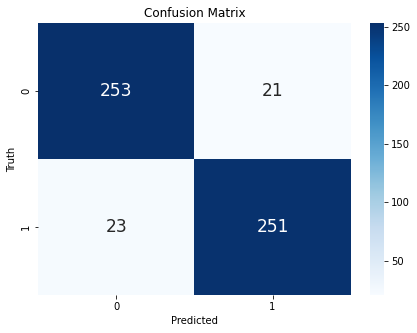

In [58]:
plt.figure(figsize=(7,5))
sns.heatmap(cm,annot=True,annot_kws={'size':17},fmt='d',cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [59]:
print(classification_report(y_predicted,y_test))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       276
           1       0.92      0.92      0.92       272

    accuracy                           0.92       548
   macro avg       0.92      0.92      0.92       548
weighted avg       0.92      0.92      0.92       548



In [61]:
reviews=[
    'Enter a chance to win $5000, hurry up, offer valid until march 31,2021.',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline.Delivery within 28 days.T Cs Box177.',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your."
]
model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.9743567 ],
       [0.9159086 ],
       [0.8946406 ],
       [0.2798463 ],
       [0.59651923]], dtype=float32)